In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_classifier(X, y, clf, ax=None, ticks=False): 
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    cs = plot_contours(ax, clf, xx, yy, cmap='rainbow', alpha=0.8)

    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap='rainbow', s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap='rainbow', s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap='rainbow', s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
    if show:
        plt.show()
    else:
        return ax

# `sklearn` Wine Dataset

In [10]:
from sklearn import datasets
from sklearn.svm import SVC

In [3]:
wine = datasets.load_wine()
wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [4]:
X = wine['data'][:, 0:2]
y = wine['target']

In [11]:
# train a linear SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

SVC(kernel='linear')

In [13]:
# make new dataset keeping only the support vectors
print(f'No. of original examples: {len(X)}')
print(f'No. of support vectors: {len(svm.support_)}')
X_small = X[svm.support_]
y_small = y[svm.support_]

No. of original examples: 178
No. of support vectors: 81


In [14]:
# train a new svm using only the support vectors
svm_small = SVC(kernel='linear')
svm_small.fit(X_small, y_small)

SVC(kernel='linear')

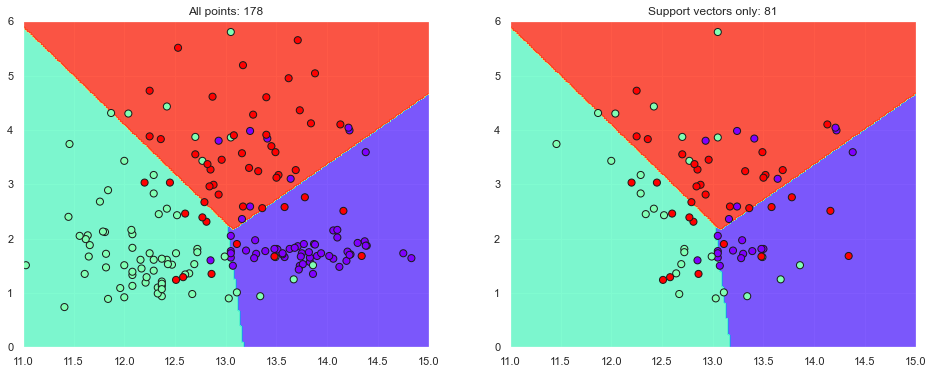

In [18]:
# visualize
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               figsize=(16, 6))

plot_classifier(X, y, svm, ax=ax1)
plot_classifier(X_small, y_small, svm_small, ax=ax2)

ax1.set_xlim(11, 15)
ax1.set_ylim(0, 6)
ax1.set_title(f'All points: {len(X)}')
ax2.set_xlim(11, 15)
ax2.set_ylim(0, 6)
ax2.set_title(f'Support vectors only: {len(svm.support_)}')

plt.show()

# `sklearn` Digits Dataset

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [20]:
digit = datasets.load_digits()
digit.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [21]:
X = digit['data']
y = digit['target'] == 2 #We only use a binary version
                         #in which we try to predict number 2

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [25]:
X_train.shape

(898, 64)

In [26]:
X_test.shape

(899, 64)

## GridSearchCV warm-up

In [27]:
# initiate RBF SVM
svm = SVC()

In [30]:
# initiate GSCV object and run search
parameters = {'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1]})

In [31]:
# report best params
print(f'Best CV params {searcher.best_params_}')

Best CV params {'gamma': 0.001}


## Jointly tuning gamma and C with GridSearchCV

In [33]:
# initiate svm
svm = SVC()

In [35]:
# initiate and GSCV and run search
parameters = {'C': [0.1, 1, 10],
              'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1]})

In [36]:
# report best params and corresponding score
print(f'best cv params: {searcher.best_params_}')
print(f'best cv acc: {searcher.best_score_}')

best cv params: {'C': 10, 'gamma': 0.0001}
best cv acc: 1.0


In [37]:
# report test acc
print(f'test acc of best params: {searcher.score(X_test, y_test)}')

test acc of best params: 0.9977753058954394


## Using SGDClassifier

In [39]:
from sklearn.linear_model import SGDClassifier

In [40]:
X = digit['data']
y = digit['target']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
X_train.shape

(1257, 64)

In [43]:
X_test.shape

(540, 64)

In [44]:
# initiate SGDClassifier
linear_classifier = SGDClassifier(random_state=0)

In [45]:
# initiate search object and run
parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
              'loss': ['hinge', 'log'],
              'penalty': ['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

GridSearchCV(cv=10, estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [48]:
# report best params and score
print(f'best cv params: {searcher.best_params_}')
print(f'best cv acc: {searcher.best_score_}')
print(f'test acc of the best params: {searcher.score(X_test, y_test)}')

best cv params: {'alpha': 0.1, 'loss': 'log', 'penalty': 'l2'}
best cv acc: 0.9570412698412699
test acc of the best params: 0.9629629629629629
